In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage.io
from operator import *
import pandas as pd

import cv2
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import skimage.feature
import os
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import xgboost
from functools import partial
import pyproj
from shapely.ops import transform
from skimage import color
from skimage import io
from collections import Counter
import xgboost

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [3]:
tiles_folder = 'brest/tiles/'

slist = sorted(os.listdir(tiles_folder))

min_i = int(slist[0].split('_')[2])
max_i = int(slist[-1].split('_')[2])

min_j = int(slist[0].split('_')[1])
max_j = int(slist[-1].split('_')[1])
print(min_i, max_i, min_j, max_j)

86411 86562 148232 148413


In [29]:
max_j-min_j

181

In [48]:
print(right_lon)

23.815612792968754


In [34]:
move_left=-0.00005
move_up=0.00005

# move_left=0
# move_up=0

# left_lon = 23.71673583984375+move_left
# right_lon = 24.00100708007812+move_left
# top_lat = 53.76657242801669+move_up
# bottom_lat = 53.60554409539466+move_up

left_lon = 23.56567382812500
right_lon = 23.84994506835938
right_lon -= 25 / (max_j - min_j + 26.0) * (right_lon - left_lon)

# left_lon += move_left
# right_lon += move_left

top_lat = 52.15118665572093+move_up
bottom_lat = 52.02292352349347+move_up



df = gpd.read_file('brest/buildings_brest_full.geojson')
df.shape

def plot_building(building):
    gpd.geodataframe.GeoDataFrame([building]).plot()

def get_building_by_coords(lat, lon):
    p = Point(lon, lat)

    assert(p.x>left_lon)
    assert(p.x<right_lon)
    
    assert(p.y>bottom_lat)
    assert(p.y<top_lat)
    
    building_index = df.geometry.centroid.distance(p).sort_values().index[0]
    return df.ix[building_index]

# plot_building(get_building_by_coords(53.684476, 23.852337))

def get_tile_coords(lat, lon):
    i = int(np.floor(np.interp(lat, [bottom_lat, top_lat], [max_i+1, min_i])))
    j = int(np.floor(np.interp(lon, [left_lon, right_lon], [min_j, max_j+1])))
#     print(j)

    assert(i >= min_i and i <= max_i)
    assert(j >= min_j and j <= max_j)
    return (i, j)

# tcoords = get_tile_coords(53.686032, 23.855658)

def get_tiles_region(building):
    bounds = building.geometry.bounds
    tiles_coords = []
    tiles_coords.append(get_tile_coords(bounds[1], bounds[0]))
    tiles_coords.append(get_tile_coords(bounds[1], bounds[2]))
    tiles_coords.append(get_tile_coords(bounds[3], bounds[0]))
    tiles_coords.append(get_tile_coords(bounds[3], bounds[2]))
    i1 = min(map(itemgetter(0), tiles_coords))
    i2 = max(map(itemgetter(0), tiles_coords))
    j1 = min(map(itemgetter(1), tiles_coords))
    j2 = max(map(itemgetter(1), tiles_coords))
    return (i1, i2, j1, j2)

# plt.imshow(get_tiles_region_image(*get_tiles_region(b)))

def get_building_image(building):
    i1, i2, j1, j2 = get_tiles_region(building)
    img = get_tiles_region_image(i1, i2, j1, j2)
#     print(i1,i2,j1,j2)
    t_left_lon = np.interp(j1, [min_j, max_j+1], [left_lon, right_lon])
    t_right_lon = np.interp(j2+1, [min_j, max_j+1], [left_lon, right_lon])
    t_top_lat = np.interp(i1, [min_i, max_i+1], [top_lat, bottom_lat])
    t_bottom_lat = np.interp(i2+1, [min_i, max_i+1], [top_lat, bottom_lat])
    
    bounds = building.geometry.bounds
    
    im_i1 = round(np.interp(bounds[3], [t_bottom_lat, t_top_lat], [img.shape[0]+1, 0]))
    im_i2 = round(np.interp(bounds[1], [t_bottom_lat, t_top_lat], [img.shape[0]+1, 0]))
    im_j1 = round(np.interp(bounds[0], [t_left_lon, t_right_lon], [0, img.shape[1]+1]))
    im_j2 = round(np.interp(bounds[2], [t_left_lon, t_right_lon], [0, img.shape[1]+1]))
    
    return img[im_i1:im_i2+1,im_j1:im_j2+1,:]

def get_building_image_by_id(id):
    building = df.ix[id]

    assert(id == building.id-1)
    return get_building_image(building)

def get_building_area(building):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(init='EPSG:32633'))
    figure = transform(project, building.geometry)
    return figure.area

def get_tiles_region_image(i1, i2, j1, j2):
    tile_size = 256
    res = np.zeros(((i2-i1+1) * tile_size, (j2-j1+1) * tile_size, 3),dtype='uint8')
    for i in range(i1, i2+1):
        for j in range(j1, j2+1):
            fname = tiles_folder + 'gs_%d_%d_18.jpg' % (j, i)
            img = skimage.io.imread(fname)
            res[(i-i1) * tile_size:(i-i1+1) * tile_size, (j-j1) * tile_size:(j-j1+1) * tile_size]=img
    return res

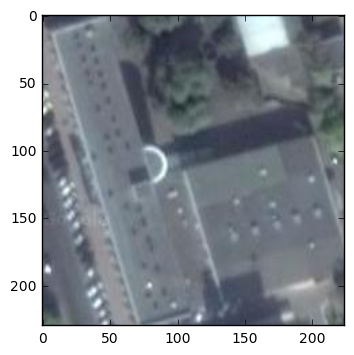

In [36]:
b = get_building_by_coords(52.086466, 23.704118)
plt.imshow(get_building_image(b))

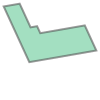

In [37]:
b.geometry

In [53]:
for i in range(len(df)):
    fname = 'data/working/all_buildings_brest/%05d.bmp' % (i + 30000)
    if os.path.isfile(fname):
        continue
    building = df.ix[i]
#     print(building.geometry.centroid)
    if building.geometry.centroid.x < left_lon + 0.001 or building.geometry.centroid.x > right_lon - 0.001 or building.geometry.centroid.y < bottom_lat + 0.001 or building.geometry.centroid.y > top_lat - + 0.001:
        print('skipping file %s' % fname)
        continue
    img = get_building_image(building)
    skimage.io.imsave(fname, img)

skipping file data/working/all_buildings_brest/30034.bmp
skipping file data/working/all_buildings_brest/30035.bmp
skipping file data/working/all_buildings_brest/44343.bmp
skipping file data/working/all_buildings_brest/44412.bmp
skipping file data/working/all_buildings_brest/44634.bmp
skipping file data/working/all_buildings_brest/44721.bmp
skipping file data/working/all_buildings_brest/44830.bmp
skipping file data/working/all_buildings_brest/44955.bmp
skipping file data/working/all_buildings_brest/44971.bmp
skipping file data/working/all_buildings_brest/45030.bmp
skipping file data/working/all_buildings_brest/45203.bmp
skipping file data/working/all_buildings_brest/45299.bmp
skipping file data/working/all_buildings_brest/45301.bmp
skipping file data/working/all_buildings_brest/45304.bmp
skipping file data/working/all_buildings_brest/45306.bmp
skipping file data/working/all_buildings_brest/45309.bmp
skipping file data/working/all_buildings_brest/45310.bmp
skipping file data/working/all_

/opt/conda/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: data/working/all_buildings_brest/52278.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)


skipping file data/working/all_buildings_brest/52707.bmp
skipping file data/working/all_buildings_brest/52710.bmp
skipping file data/working/all_buildings_brest/52711.bmp
skipping file data/working/all_buildings_brest/52712.bmp
skipping file data/working/all_buildings_brest/52713.bmp
skipping file data/working/all_buildings_brest/52714.bmp
skipping file data/working/all_buildings_brest/52715.bmp
skipping file data/working/all_buildings_brest/52716.bmp
skipping file data/working/all_buildings_brest/52718.bmp
skipping file data/working/all_buildings_brest/52719.bmp
skipping file data/working/all_buildings_brest/52720.bmp
skipping file data/working/all_buildings_brest/52721.bmp
skipping file data/working/all_buildings_brest/52722.bmp
skipping file data/working/all_buildings_brest/52723.bmp
skipping file data/working/all_buildings_brest/52724.bmp
skipping file data/working/all_buildings_brest/52725.bmp
skipping file data/working/all_buildings_brest/52726.bmp
skipping file data/working/all_

In [237]:
Counter(df['type'])

Counter({'322': 1,
         '353': 1,
         '412': 1,
         'administrative': 26,
         'apartments': 1018,
         'apartments;dormitory': 1,
         'basilica': 1,
         'cathedral': 2,
         'chapel': 1,
         'church': 13,
         'college': 1,
         'commercial': 40,
         'construction': 60,
         'detached': 39,
         'dormitory': 35,
         'garage': 29,
         'garages': 528,
         'greenhouse': 2,
         'hangar': 7,
         'hospital': 43,
         'house': 4521,
         'hut': 3,
         'industrial': 1728,
         'kindergarten': 30,
         'manufacture': 102,
         'office': 16,
         'part': 3,
         'public': 777,
         'residential': 9386,
         'retail': 42,
         'roof': 38,
         'ruins': 2,
         'school': 62,
         'service': 10,
         'shed': 2,
         'sport': 1,
         'store': 8,
         'tent': 2,
         'train_station': 1,
         'university': 12,
         'warehouse': 29,

In [13]:
get_building_area(b)

38447.65159798621

In [127]:
df_labels = pd.read_csv('data/input/roofs_labeled.csv')

In [40]:
%%time
images_arr = []
for (ind, label) in df_labels.values:#[df_labels['is_flat'] == -1][:10].values:
    img = get_building_image_by_id(ind)
    images_arr.append(img)
#     plt.title('label: %d' % label)
#     plt.imshow(img)
#     plt.show()

CPU times: user 5.75 s, sys: 178 ms, total: 5.93 s
Wall time: 5.93 s


In [57]:
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [55]:
# b = get_building_by_coords(53.662562, 23.872029)
# b = get_building_image_by_id(0)
img = get_building_image_by_id(0)
# img = color.rgb2gray(img)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [45]:
img = color.rgb2gray(images_arr[0])

In [58]:
sift.detectAndCompute(convert_to_gray(img), None)

error: /opencv-3.1.0/modules/imgproc/src/color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


In [63]:
images

2000

In [ ]:
images=[]
for img_rgb in images_arr:
    img = convert_to_gray(img_rgb)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descriptors = sift.detectAndCompute(img, None)
    images.append((img, descriptors))

In [66]:
all_descriptors = []
for img, descriptors in images:
    if descriptors == None:
        continue
    all_descriptors.extend(descriptors)
#     print('asdf')

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


In [191]:
%%time
n_clusters = 5000
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, verbose = True).fit(all_descriptors)

Init 1/3 with method: k-means++


/opt/conda/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1383: RuntimeWarning: init_size=300 should be larger than k=5000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 1104700.833333
Init 2/3 with method: k-means++
Inertia for init 2/3: 1214076.333333
Init 3/3 with method: k-means++
Inertia for init 3/3: 1231658.166667
Minibatch iteration 1/150000: mean batch inertia: 82429.039722, ewa inertia: 82429.039722 
Minibatch iteration 2/150000: mean batch inertia: 79740.237500, ewa inertia: 82425.452763 
Minibatch iteration 3/150000: mean batch inertia: 75476.834167, ewa inertia: 82416.183057 
Minibatch iteration 4/150000: mean batch inertia: 76010.670556, ewa inertia: 82407.637873 
Minibatch iteration 5/150000: mean batch inertia: 79041.561806, ewa inertia: 82403.147406 
Minibatch iteration 6/150000: mean batch inertia: 77805.535486, ewa inertia: 82397.014027 
Minibatch iteration 7/150000: mean batch inertia: 80703.492906, ewa inertia: 82394.754809 
Minibatch iteration 8/150000: mean batch inertia: 79903.163411, ewa inertia: 82391.430936 
Minibatch iteration 9/150000: mean batch inertia: 77084.092994, ewa inertia: 82384.350757 
[MiniB

In [193]:
def compute_histogram(a, n_clusters):
    histogram = np.bincount(a, minlength = n_clusters)
    return histogram / histogram.sum()

id  is_flat
0        0        1
1        3        0
2        5        0
3        9        1
4       10        1
5       11        0
6       12        1
7       17        1
8       18        1
9       19        1
10      20        0
11      22        1
12      23        1
13      24        0
14      25        1
15      26        1
16      27        0
17      28        1
18      30        1
19      31        1
20      33        1
21      34        1
22      41        1
23      42        0
24      43        1
25      44        0
26      46        1
27      48        1
28     118        1
29     119        1
...    ...      ...
1970  6030        0
1971  6031        0
1972  6032        0
1973  6033        0
1974  6034       -1
1975  6035        0
1976  6036        0
1977  6037        0
1978  6038        0
1979  6039        0
1980  6040        0
1981  6041        0
1982  6043        0
1983  6044        0
1984  6047        0
1985  6049        0
1986  6050        0
1987  6051        0
1988  6055        0
1989  6056        0
1990  6061        0
1991  6070       -1
1992  6073        0
1993  6075        0
1994  6086       -1
1995  6105        0
1996  6161       -1
1997  6175        0
1998  6200       -1
1999  6228       -1

[2000 rows x 2 columns]

In [194]:
X = []
for img, descriptors in images:
    descs = descriptors
    if descs == None:
        labels = []
    else:
        labels = kmeans.predict(descs)
    X.append(compute_histogram(labels, n_clusters))
X = np.array(X)

Y = df_labels['is_flat'].copy().values
# Y[Y==-1]=0

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

In [195]:
inds = (Y>=0).nonzero()[0]
X = X[inds]
Y = Y[inds]

In [205]:
from sklearn.cross_validation import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.2)
train_index, val_index = next(sss.split(X, Y))
X_train, X_test = X[train_index], X[val_index]
y_train, y_test = Y[train_index], Y[val_index]

In [224]:
# model = Pipeline([
#     ('xgb', xgboost.XGBClassifier(n_estimators=400, max_depth=3))
# ])
# model.fit(X_train, y_train)

model = Pipeline([
    ('fillna', Imputer()),
    ('pca', PCA(n_components=1000, random_state=0)),
    ('scaler', StandardScaler()),
    ('svm', SVC(C=3))
])
model.fit(X_train, y_train)

Pipeline(steps=[('fillna', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('pca', PCA(copy=True, iterated_power='auto', n_components=1000, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm'...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [225]:
pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.71225071225071224

In [164]:
for i in range(len(df)):
    fname = 'data/working/all_buildings/%05d.bmp' % i
    if os.path.isfile(fname):
        continue
    building = df.ix[i]
    if building.geometry.centroid.x < left_lon or building.geometry.centroid.x > right_lon or building.geometry.centroid.y < bottom_lat or building.geometry.centroid.y > top_lat:
        print('skipping file %s' % fname)
        continue
    img = get_building_image(building)
    skimage.io.imsave(fname, img)

skipping file data/working/all_buildings/12602.bmp
skipping file data/working/all_buildings/12614.bmp
skipping file data/working/all_buildings/13255.bmp
skipping file data/working/all_buildings/13256.bmp
skipping file data/working/all_buildings/13262.bmp
skipping file data/working/all_buildings/13263.bmp
skipping file data/working/all_buildings/13264.bmp
skipping file data/working/all_buildings/13286.bmp


/opt/conda/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: data/working/all_buildings/13328.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)


skipping file data/working/all_buildings/13410.bmp
skipping file data/working/all_buildings/15324.bmp
skipping file data/working/all_buildings/15348.bmp
skipping file data/working/all_buildings/15349.bmp
skipping file data/working/all_buildings/15350.bmp
skipping file data/working/all_buildings/15352.bmp
skipping file data/working/all_buildings/15353.bmp
skipping file data/working/all_buildings/15354.bmp
skipping file data/working/all_buildings/15355.bmp
skipping file data/working/all_buildings/15356.bmp
skipping file data/working/all_buildings/15357.bmp
skipping file data/working/all_buildings/15358.bmp
skipping file data/working/all_buildings/15359.bmp
skipping file data/working/all_buildings/15360.bmp
skipping file data/working/all_buildings/15361.bmp
skipping file data/working/all_buildings/15362.bmp
skipping file data/working/all_buildings/15363.bmp
skipping file data/working/all_buildings/15364.bmp
skipping file data/working/all_buildings/15367.bmp
skipping file data/working/all_

/opt/conda/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: data/working/all_buildings/21748.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: data/working/all_buildings/21749.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)


skipping file data/working/all_buildings/22126.bmp
skipping file data/working/all_buildings/22127.bmp
skipping file data/working/all_buildings/22128.bmp
skipping file data/working/all_buildings/22129.bmp
skipping file data/working/all_buildings/22131.bmp
skipping file data/working/all_buildings/22132.bmp
skipping file data/working/all_buildings/22133.bmp
skipping file data/working/all_buildings/22134.bmp
skipping file data/working/all_buildings/22135.bmp
skipping file data/working/all_buildings/22136.bmp
skipping file data/working/all_buildings/22137.bmp
skipping file data/working/all_buildings/22138.bmp
skipping file data/working/all_buildings/22145.bmp
skipping file data/working/all_buildings/22151.bmp
skipping file data/working/all_buildings/22155.bmp
skipping file data/working/all_buildings/22162.bmp
skipping file data/working/all_buildings/22163.bmp
skipping file data/working/all_buildings/22166.bmp
skipping file data/working/all_buildings/22183.bmp
skipping file data/working/all_

/opt/conda/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: data/working/all_buildings/24025.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)


skipping file data/working/all_buildings/24999.bmp
skipping file data/working/all_buildings/25000.bmp
skipping file data/working/all_buildings/25001.bmp
skipping file data/working/all_buildings/25002.bmp
skipping file data/working/all_buildings/25003.bmp
skipping file data/working/all_buildings/25018.bmp
skipping file data/working/all_buildings/25019.bmp
skipping file data/working/all_buildings/25020.bmp
skipping file data/working/all_buildings/25411.bmp
skipping file data/working/all_buildings/25737.bmp
skipping file data/working/all_buildings/25738.bmp
skipping file data/working/all_buildings/25740.bmp
skipping file data/working/all_buildings/26170.bmp


In [21]:
b = get_building_by_coords(53.662562, 23.872029)
img = get_building_image(b)

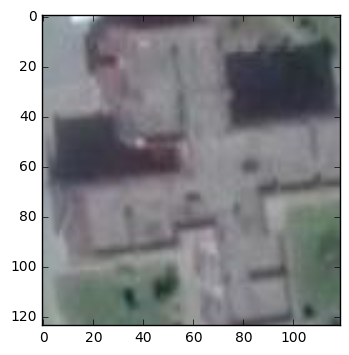

In [30]:
plt.imshow(img)

In [37]:
images[0]

2

In [24]:
img_gray = color.rgb2gray(img)

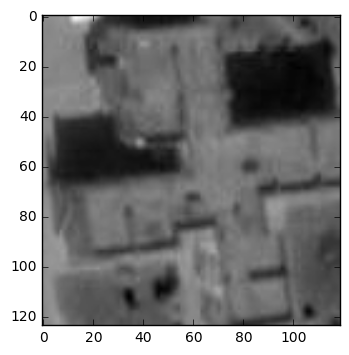

In [27]:
plt.imshow(img_gray, cmap='gray')

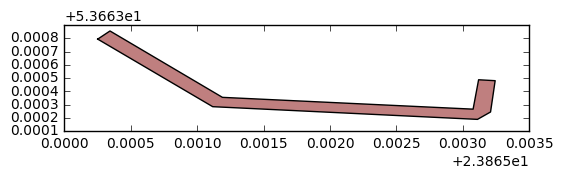

In [139]:
plot_building(b)

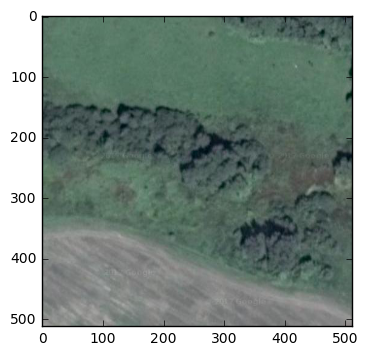

In [16]:
print(min_i, max_i, min_j, max_j)

148342 148548 84458 84655


In [8]:
slist[0]

'gs_148342_84458_18.jpg'

In [9]:
slist[-1]

'gs_148548_84655_18.jpg'

In [239]:
all_results_grodno = pd.read_csv('data/input/all_results_grodno.csv')

In [250]:
flat_buildings_ids = all_results_grodno[all_results_grodno['is_flat'] == 1]['id'].values
bad_buildings_ids = all_results_grodno[all_results_grodno['is_flat'] == 0]['id'].values

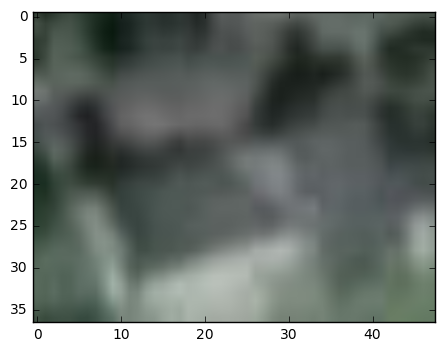

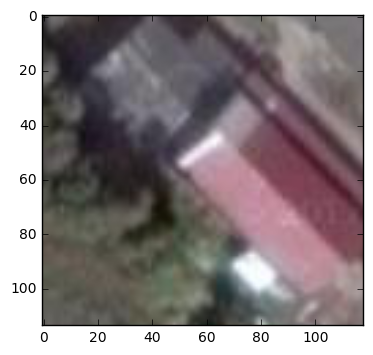

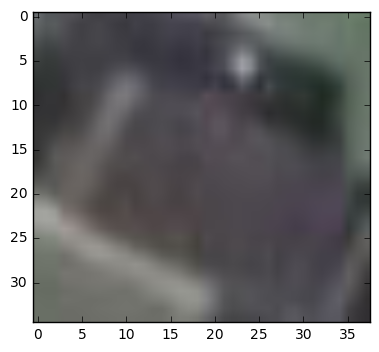

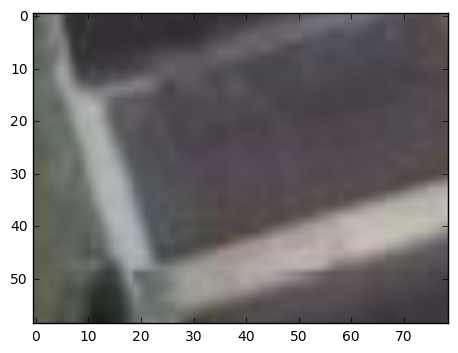

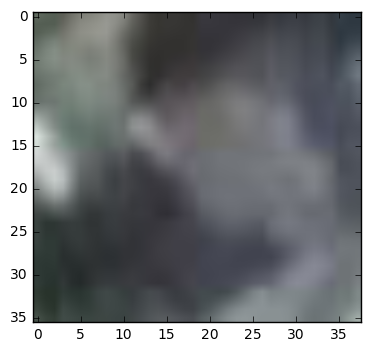

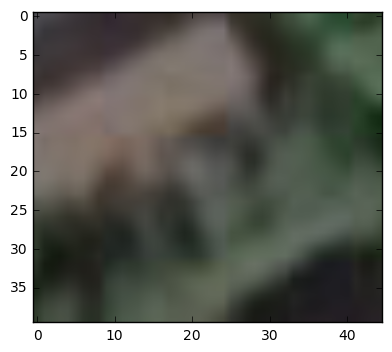

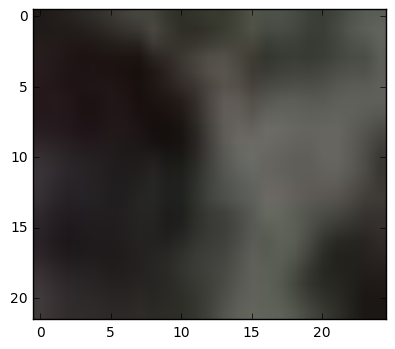

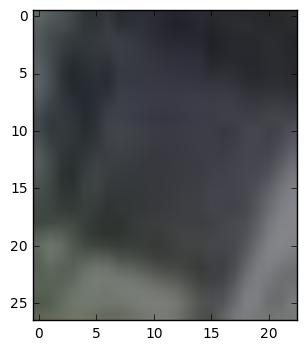

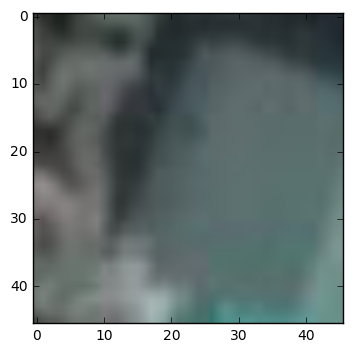

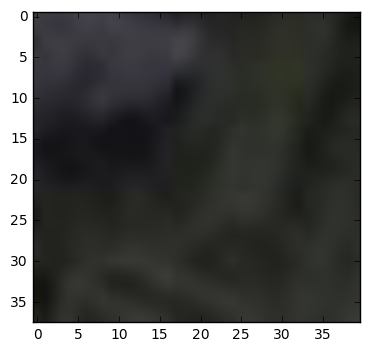

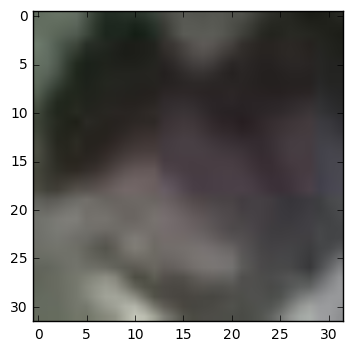

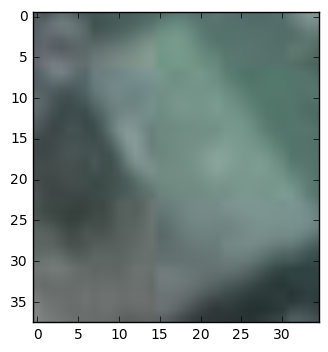

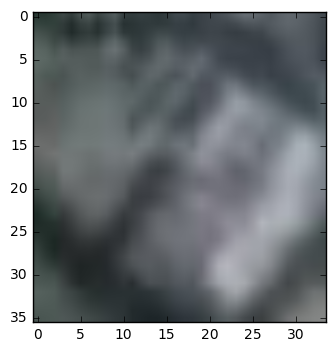

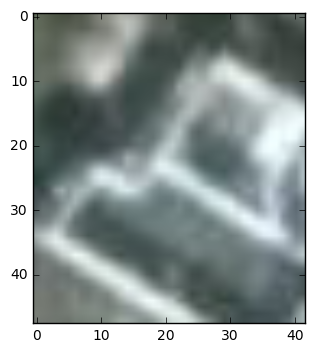

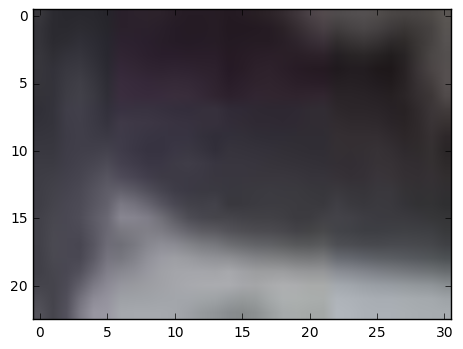

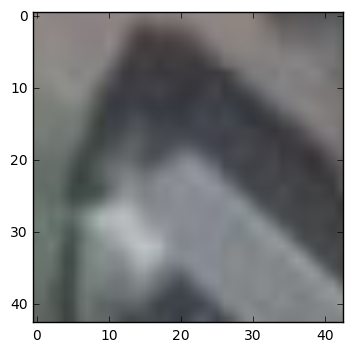

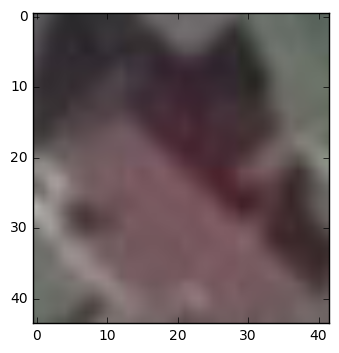

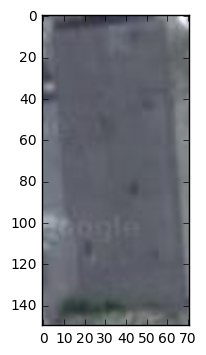

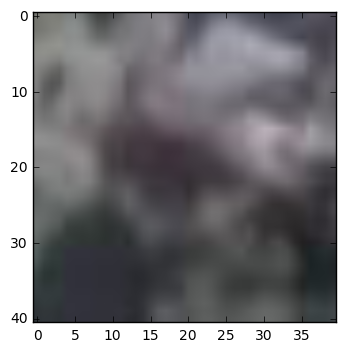

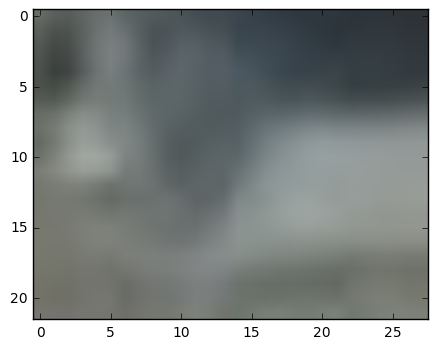

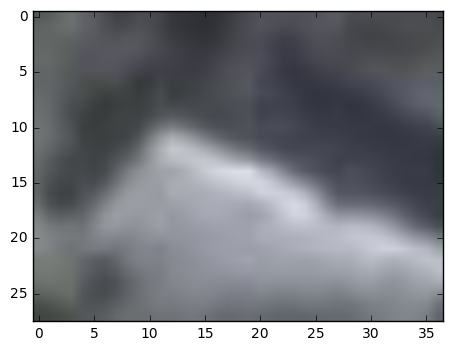

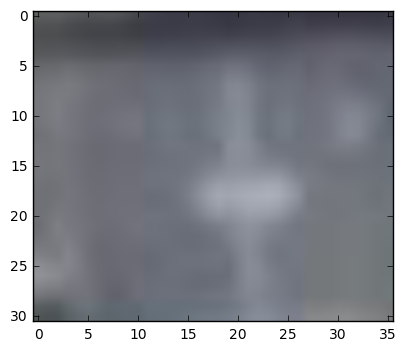

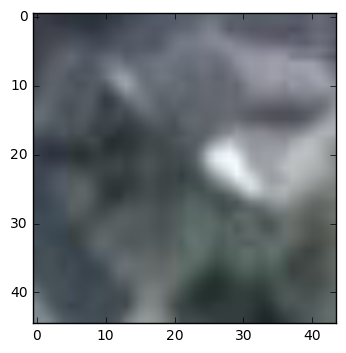

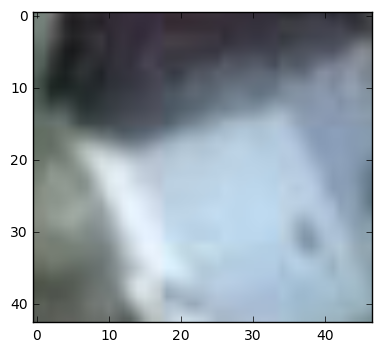

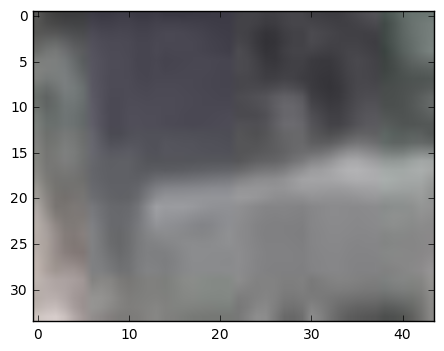

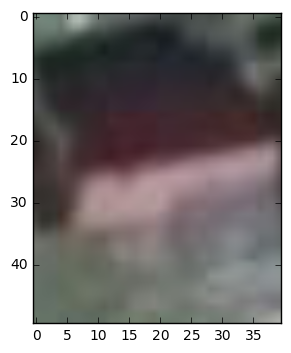

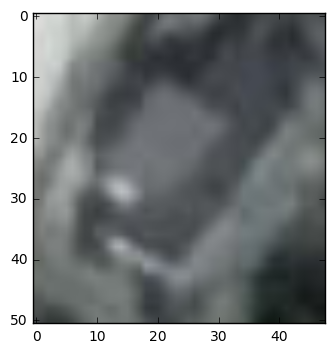

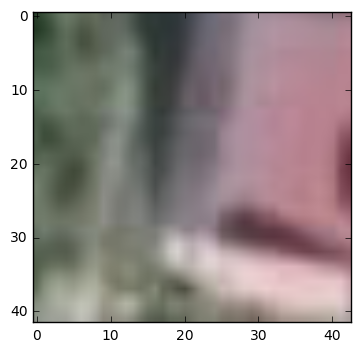

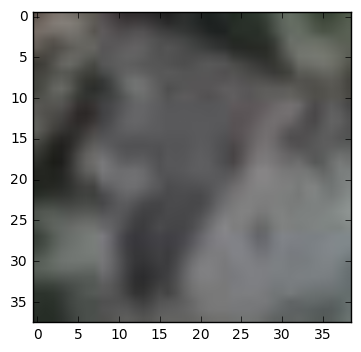

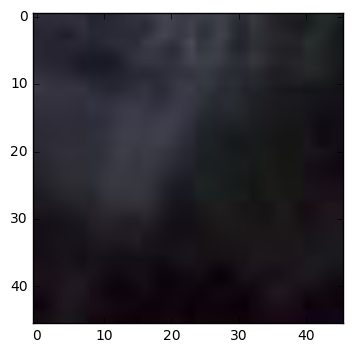

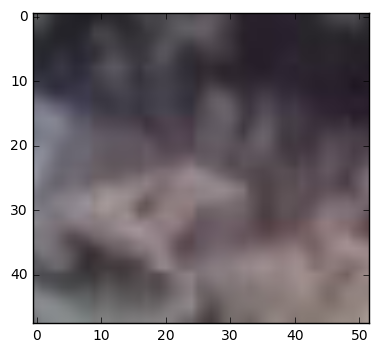

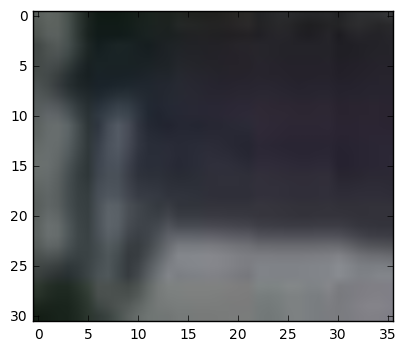

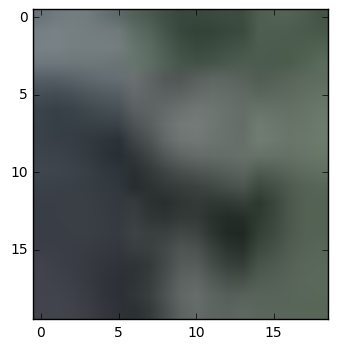

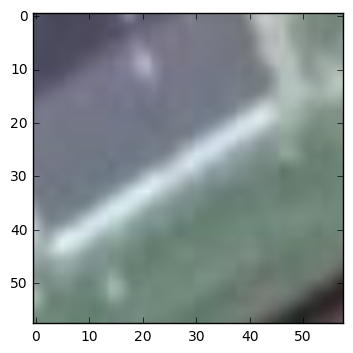

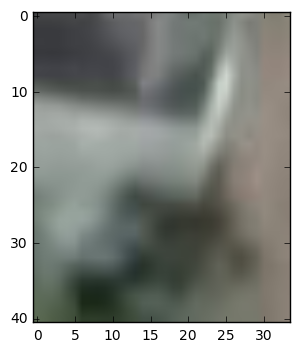

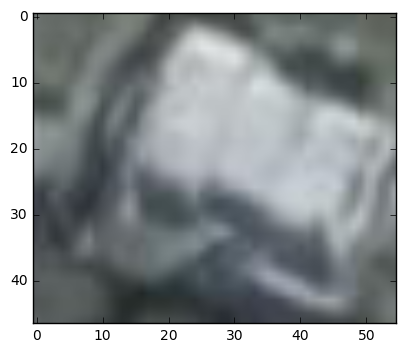

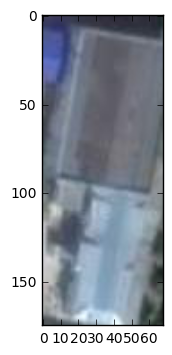

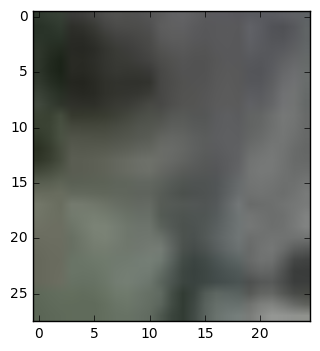

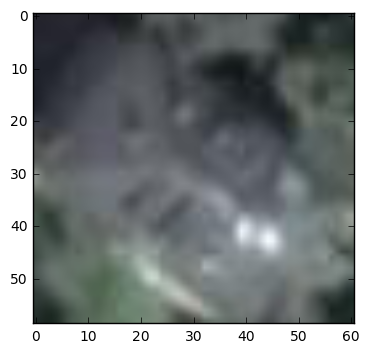

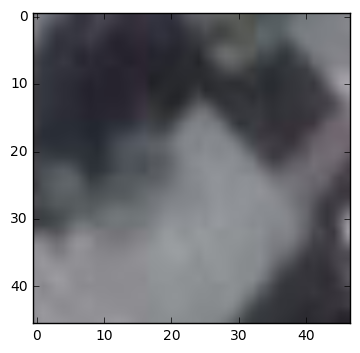

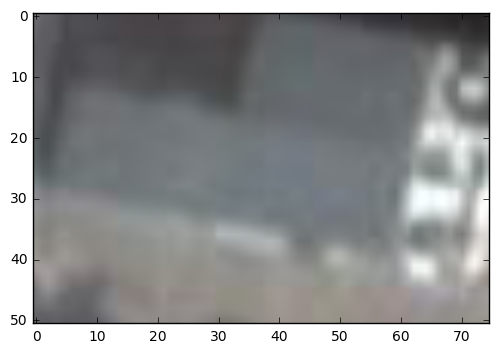

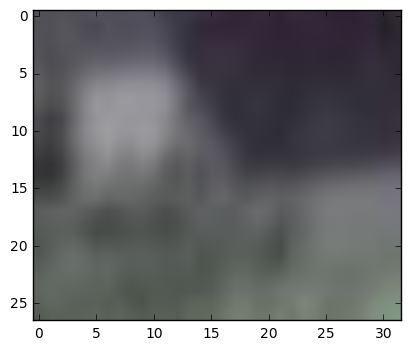

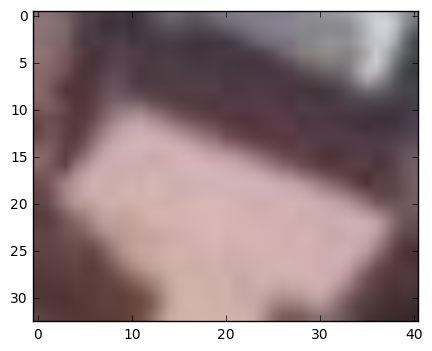

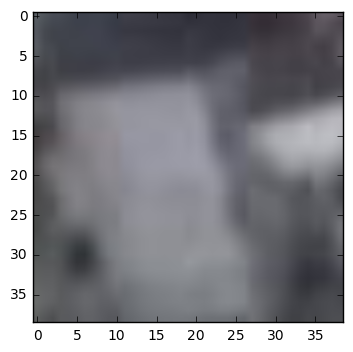

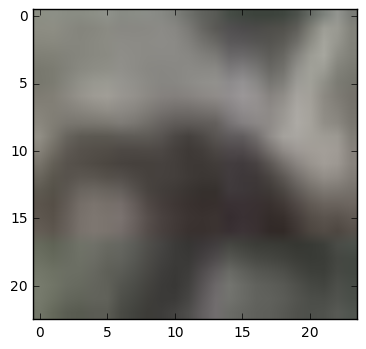

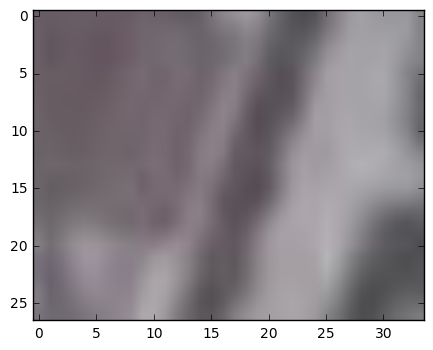

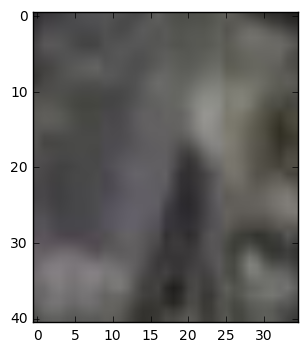

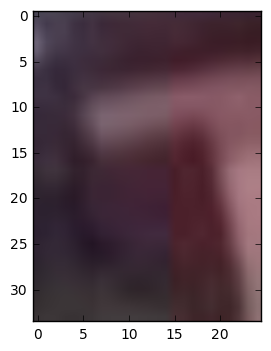

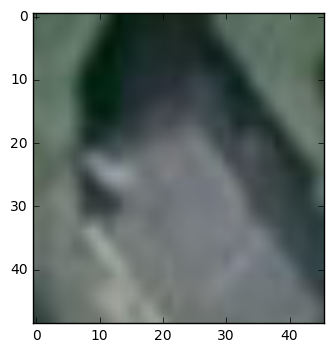

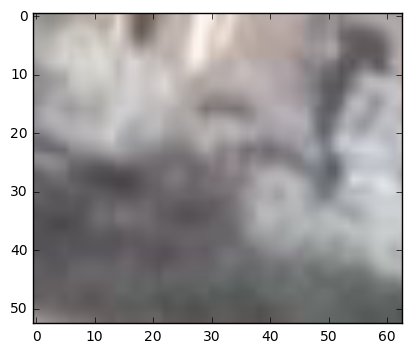

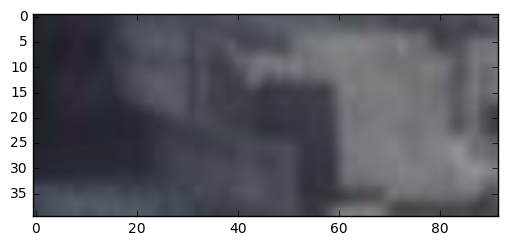

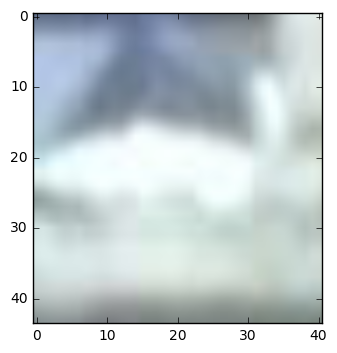

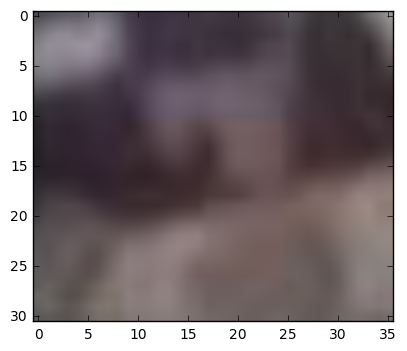

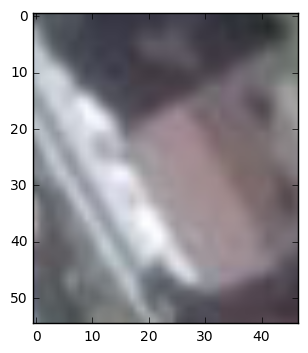

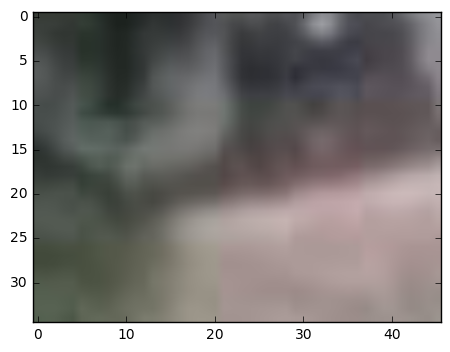

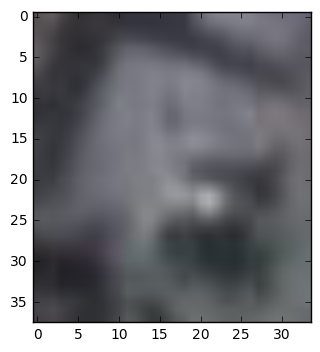

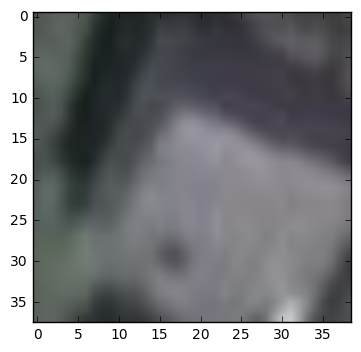

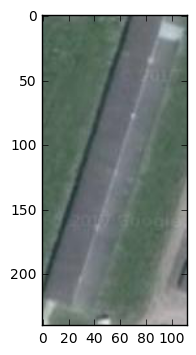

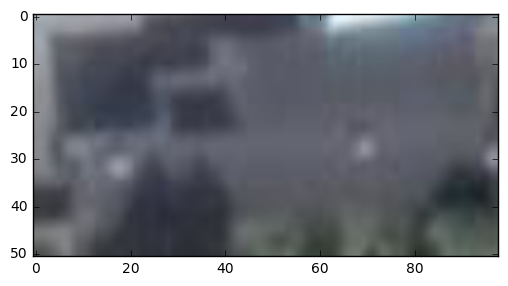

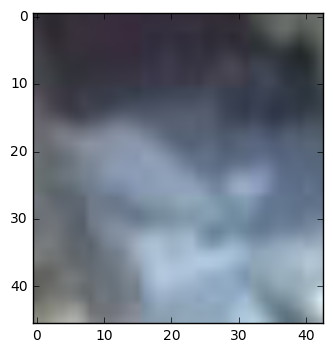

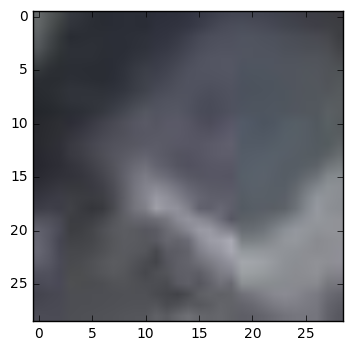

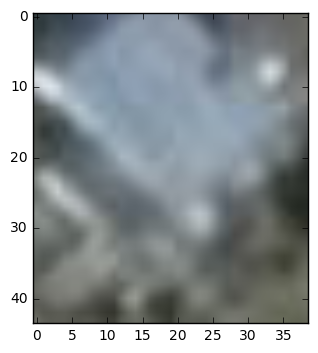

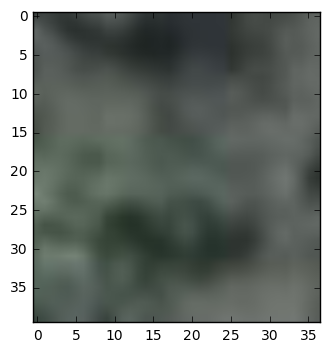

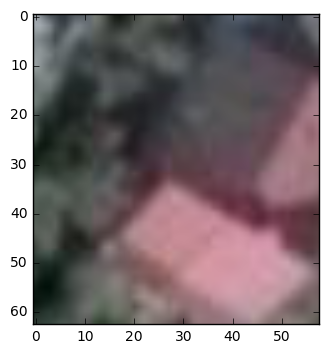

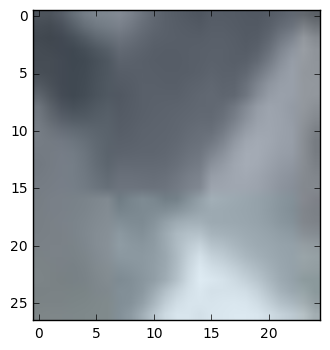

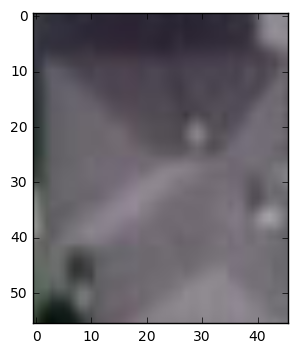

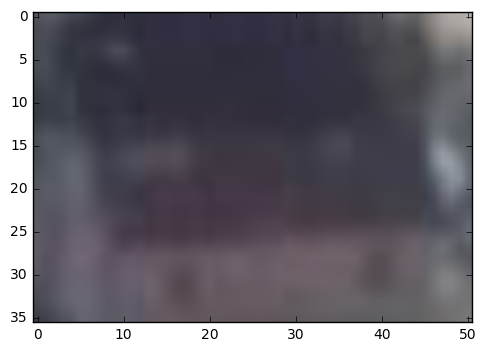

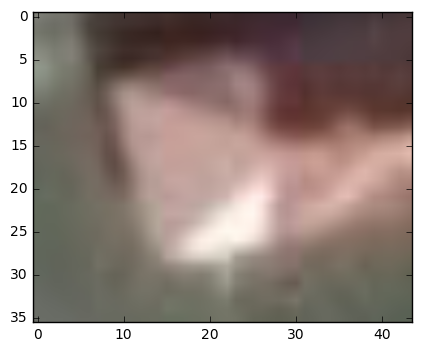

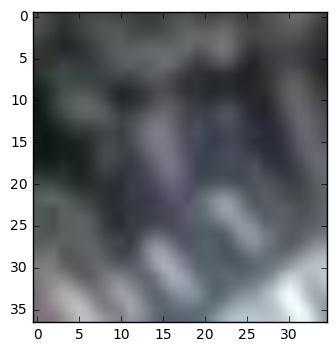

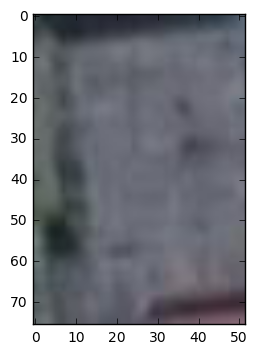

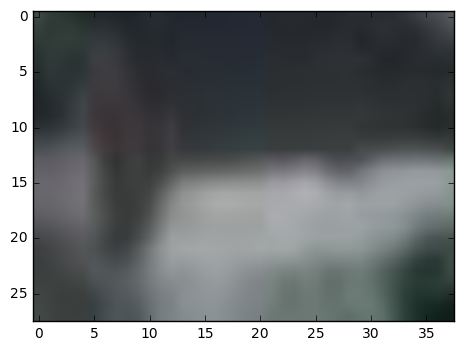

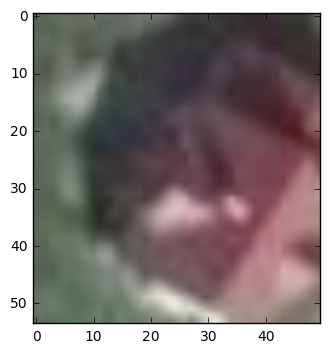

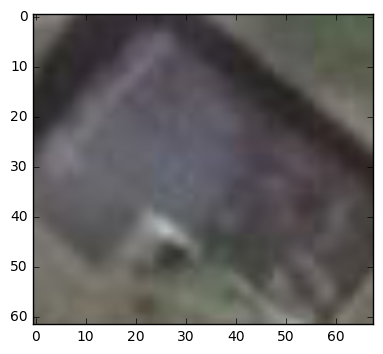

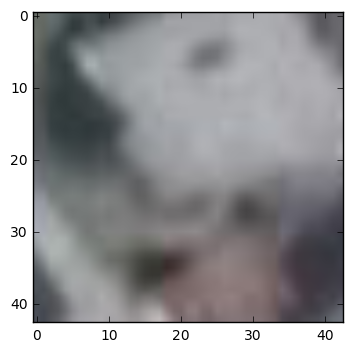

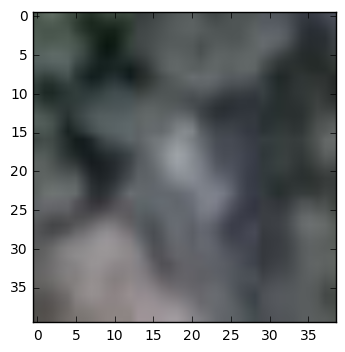

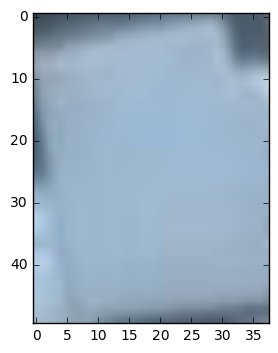

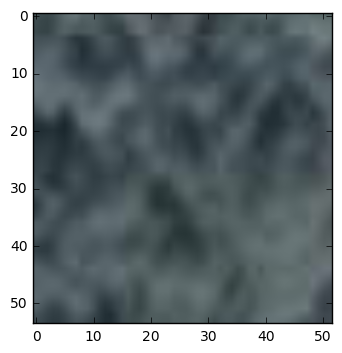

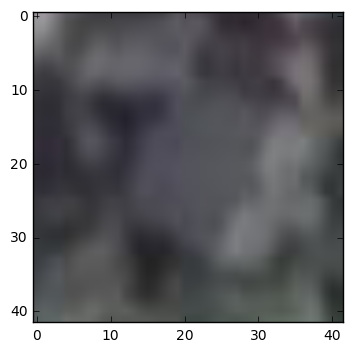

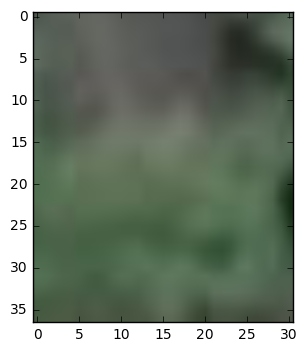

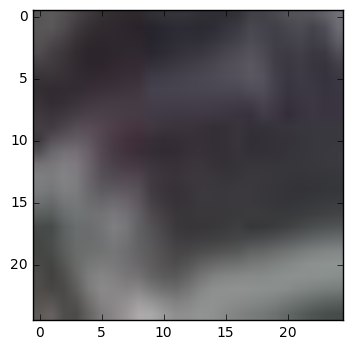

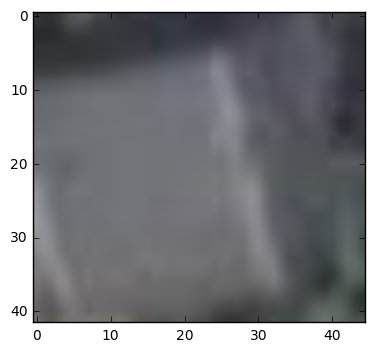

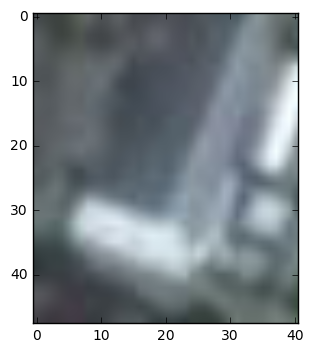

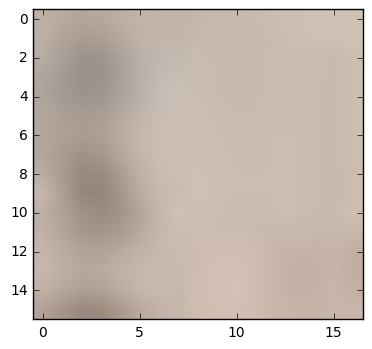

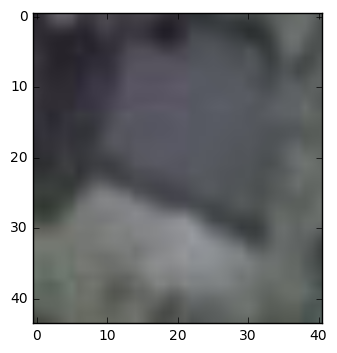

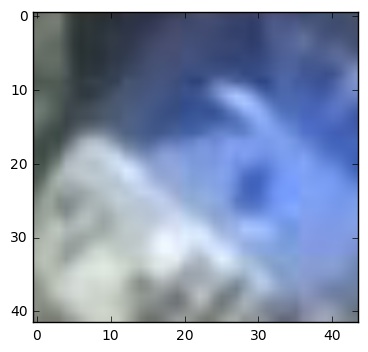

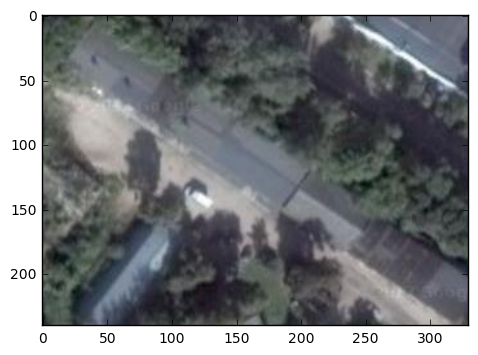

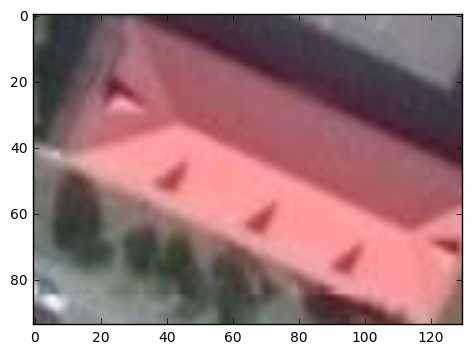

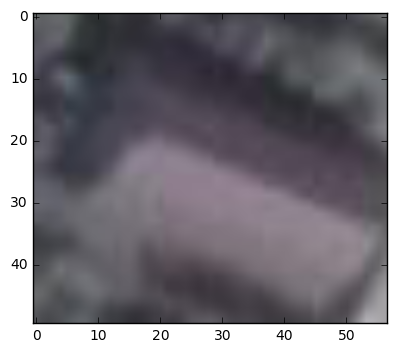

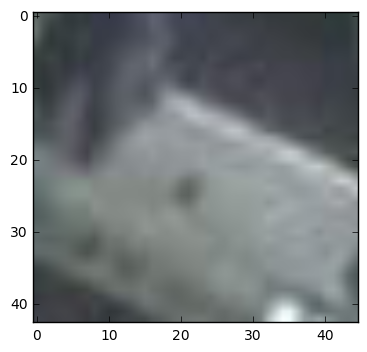

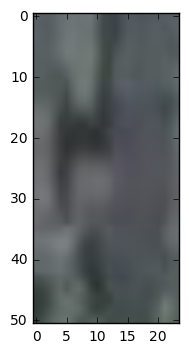

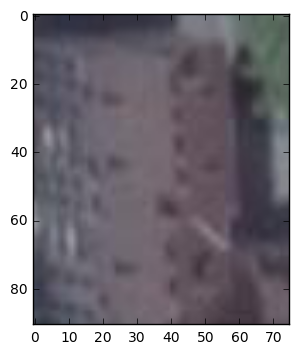

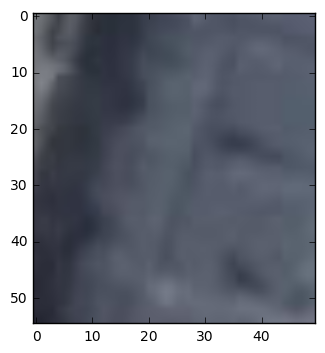

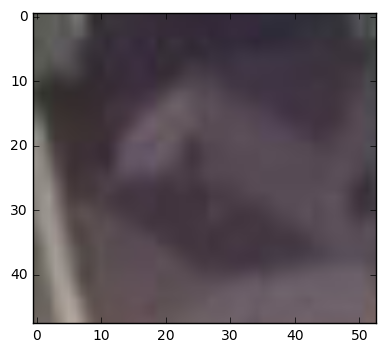

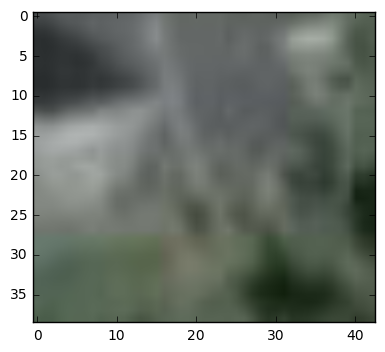

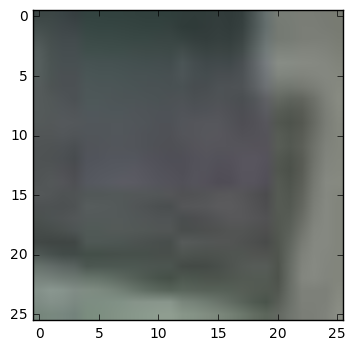

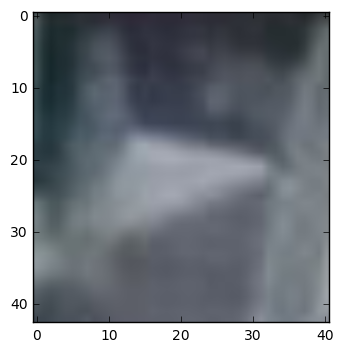

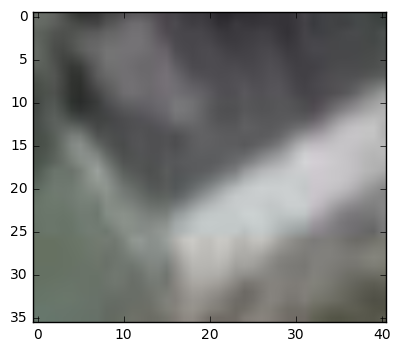

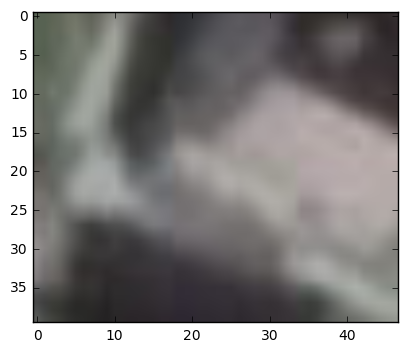

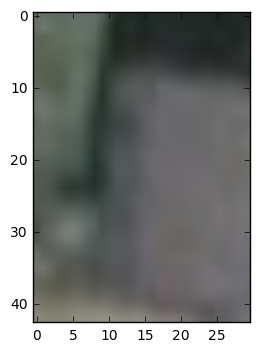

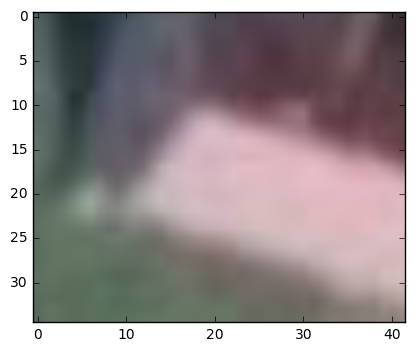

In [252]:
for bid in bad_buildings_ids[15000:15100]:
    plt.imshow(get_building_image_by_id(bid))
    plt.show()

In [263]:
total_area = 0
for index in all_results_grodno['id'].values:
    building = df.ix[index]
    total_area += get_building_area(building)

In [264]:
total_area

9665067.162541945

In [262]:
total_flat_area = 0
for index in all_results_grodno['id'][all_results_grodno['is_flat'] == 1].values:
    building = df.ix[index]
    total_flat_area += get_building_area(building)

In [265]:
total_flat_area

4775132.196362982

In [259]:
df.ix[0]

geometry    POLYGON ((23.82904794213246 53.6862777910406, ...
id                                                          1
name                                                     None
osm_id                                                 -61784
type                                                   public
Name: 0, dtype: object